In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.wrappers import TimeLimit
import time

In [2]:
def epsilon_greedy_policy(Q, state, epsilon, action_mask):
    #print(action_mask)
    #valid_actions = np.where(action_mask == 1)[0]
    #print(valid_actions)
    if np.random.rand() < epsilon:
        #chosen_action = np.random.choice(valid_actions) 
        chosen_action = np.random.choice(range(6))
        #print(f"Random action chosen: {chosen_action}")
        return chosen_action
    else:
        #valid_Q = Q[state, valid_actions]
        #chosen_action = valid_actions[np.argmax(valid_Q)]
        chosen_action = np.argmax(Q[state])
        #print(f"Greedy action chosen: {chosen_action}")
        return chosen_action

In [3]:
def is_action_valid(env, state, action, action_mask):
    
    taxi_row, taxi_col, pass_loc, dest = list(env.unwrapped.decode(state))
    # if action_mask[action] == 0:
    #     return False
    # # # Check if the pickup action is valid
    if action == 4:
        if pass_loc == 4:  # Passenger is already in the taxi
            return False
        if (taxi_row, taxi_col) == env.unwrapped.locs[pass_loc]:
            return True
        else:
            return False

    # Check if the drop-off action is valid
    if action == 5:
        if pass_loc != 4:  # Passenger is not in the taxi
            return False
        if (taxi_row, taxi_col) == env.unwrapped.locs[dest]:
            return True
        else:
            return False

    # All other actions are always valid
    return True

In [4]:
def monte_carlo(env, episodes, gamma=0.99, initial_epsilon=1.0, min_epsilon=0.1, decay_rate=0.99, alpha=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    returns = {s: {a: [] for a in range(env.action_space.n)} for s in range(env.observation_space.n)}
    all_rewards = []

    epsilon = initial_epsilon
    
    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        episode_data = []
        total_reward = 0
        i=0
        while not done:
            i+=1
            _, _, _, _, info = env.step(0)  # Get the initial action_mask
            #print(f"State: {state}, Taxi position: {list(env.unwrapped.decode(state))[:2]}, Action mask: {info['action_mask']}")
            action = epsilon_greedy_policy(Q, state, epsilon, info["action_mask"])
            # Ensure action validity
            while not is_action_valid(env, state, action, info["action_mask"]):
                action = epsilon_greedy_policy(Q, state, epsilon, info['action_mask'])
            next_state, reward, done, truncated, info = env.step(action)
            if (i%10000 ==0):
                print(f"Episode {episode}, Reward: {reward}, Action: {action}, i is {i}")
            episode_data.append((state, action, reward))
            state = next_state
            total_reward += reward
            #env.render()
            #time.sleep(50)
            # if done or truncated:
            #     break

        all_rewards.append(total_reward)
        G = 0
        for state, action, reward in reversed(episode_data):
            G = reward + gamma * G
            if not any((s == state and a == action) for s, a, _ in episode_data[:-1]):
                returns[state][action].append(G)
                Q[state][action] = np.mean(returns[state][action])

        # Dynamic epsilon decay based on performance
        epsilon = max(min_epsilon, initial_epsilon * decay_rate ** (episode / 100))

        # Logging for debugging
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")
    #env.close()
    return Q, all_rewards

In [9]:
# def monte_carlo(env, episodes, gamma=0.99, initial_epsilon=1.0, min_epsilon=0.1, decay_rate=0.99, alpha=0.1):
#     Q = np.zeros((env.observation_space.n, env.action_space.n))
#     returns = {s: {a: [] for a in range(env.action_space.n)} for s in range(env.observation_space.n)}
#     policy = np.zeros(env.observation_space.n, dtype=int)
#     all_rewards = []

#     epsilon = initial_epsilon
#     for episode in range(episodes):
#         state = env.reset()[0]
#         done = False
#         episode_data = []
#         total_reward = 0

#         while not done:
#             _, _, _, _, info = env.step(0)  # Get the initial action_mask
#             action = epsilon_greedy_policy(Q, state, epsilon, info['action_mask'])
#             #while not is_action_valid(env, state, action):
#             #   action = epsilon_greedy_policy(Q, state, epsilon, info['action_mask'])
#             next_state, reward, done, truncated, info = env.step(action)
#             print(f"Reward: {reward}, Action: {action}, Episode: {episode}")
#             episode_data.append((state, action, reward))
#             state = next_state
#             total_reward += reward
            
#             # if done or truncated:
#             #     break

#         all_rewards.append(total_reward)
#         print(f"Reward: {reward}, Action: {action}, Episode: {episode}, Total Reward: {total_reward} ")
#         G = 0
#         for state, action, reward in reversed(episode_data):
#             G = reward + gamma * G
#             if not any((s == state and a == action) for s, a, _ in episode_data[:-1]):
#                 returns[state][action].append(G)
#                 Q[state][action] = np.mean(returns[state][action])

#         # Update policy to be the action with highest Q-value for each state
#         for state in range(env.observation_space.n):
#             policy[state] = np.argmax(Q[state])

#         # Decay epsilon
#         epsilon = max(min_epsilon, epsilon * decay_rate)

#     return Q, policy, all_rewards


In [6]:
def td_learning(env, episodes, alpha=0.1, gamma=0.99, initial_epsilon=1.0, min_epsilon=0.1, decay_rate=0.99):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    epsilon = initial_epsilon
    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        
        while not done:
            _, _, _, _, info = env.step(0)
            action = epsilon_greedy_policy(Q, state, epsilon, info['action_mask'])  # Random policy
            next_state, reward, done, truncated, info = env.step(action)
            best_next_action = np.argmax(Q[next_state])
            #print(type(next_state) ,action)
            
            Q[state, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])
            state = next_state
            total_reward += reward
            print(f"Reward: {reward}, Action: {action}, Episode: {episode}, Total Reward: {total_reward} ")
            if done or truncated:
                break
            
        rewards.append(total_reward)
        epsilon = max(min_epsilon, epsilon * decay_rate)
    
    return Q, rewards

In [9]:
def plot_rewards(mc_rewards):
  fig, ax = plt.subplots(figsize=(12, 6))  # Create figure and axis objects
  ax.plot(mc_rewards, label='Monte Carlo', color = 'b')  # Use ax for plotting on the axis
  #ax.plot(td_rewards, label='TD Learning', color = 'r')  # Uncomment if needed
  ax.set_xlabel('Episodes')  # Set labels using ax object
  ax.set_ylabel('Cumulative Reward')
  ax.legend()
  plt.show()

In [17]:
max_episode_length = 30000000
env = gym.make("Taxi-v3")
env = TimeLimit(env, max_episode_steps=max_episode_length)
episodes = 5000
#print(type(env.unwrapped.decode(1)))
mc_Q, mc_rewards = monte_carlo(env, episodes)

Episode 0, Reward: -1, Action: 0, i is 10000
Episode 0, Reward: -1, Action: 3, i is 20000
Episode 0, Reward: -1, Action: 2, i is 30000
Episode 0, Reward: -1, Action: 3, i is 40000
Episode 0, Reward: -1, Action: 3, i is 50000
Episode 0, Reward: -1, Action: 2, i is 60000
Episode 0, Reward: -1, Action: 0, i is 70000
Episode 0, Reward: -1, Action: 2, i is 80000
Episode 0, Reward: -1, Action: 2, i is 90000
Episode 0, Reward: -1, Action: 1, i is 100000
Episode 0, Reward: -1, Action: 1, i is 110000
Episode 0, Reward: -1, Action: 2, i is 120000
Episode 0, Reward: -1, Action: 0, i is 130000
Episode 0, Reward: -1, Action: 3, i is 140000
Episode 0, Reward: -1, Action: 0, i is 150000
Episode 0, Reward: -1, Action: 2, i is 160000
Episode 0, Reward: -1, Action: 2, i is 170000
Episode 0, Reward: -1, Action: 1, i is 180000
Episode 0, Reward: -1, Action: 3, i is 190000
Episode 0, Reward: -1, Action: 0, i is 200000
Episode 0, Reward: -1, Action: 0, i is 210000
Episode 0, Reward: -1, Action: 3, i is 2200

KeyboardInterrupt: 

: 

In [ ]:
#print(mc_policy)
def choose_action(policy, state, action_mask):
    valid_actions = np.where(action_mask == 1)[0]
    return np.argmax(policy[state])

In [ ]:
env = gym.make("Taxi-v3", render_mode="human")
state, info = env.reset()
done = False

while not done:
    action = choose_action(mc_policy, state, info['action_mask'])
    print(action)
    state, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        break

env.close()

In [ ]:
max_episode_length = 2000
env = gym.make("Taxi-v3")
env = TimeLimit(env, max_episode_steps=max_episode_length)
episodes = 5000
td_Q, td_rewards = td_learning(env, episodes)

[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 ...
 [ -1.   0.  -1.   0. -10. -10.]
 [ -1.  -1.  -1.   0. -10.   0.]
 [  0.   0.   0.   0.   0.   0.]]


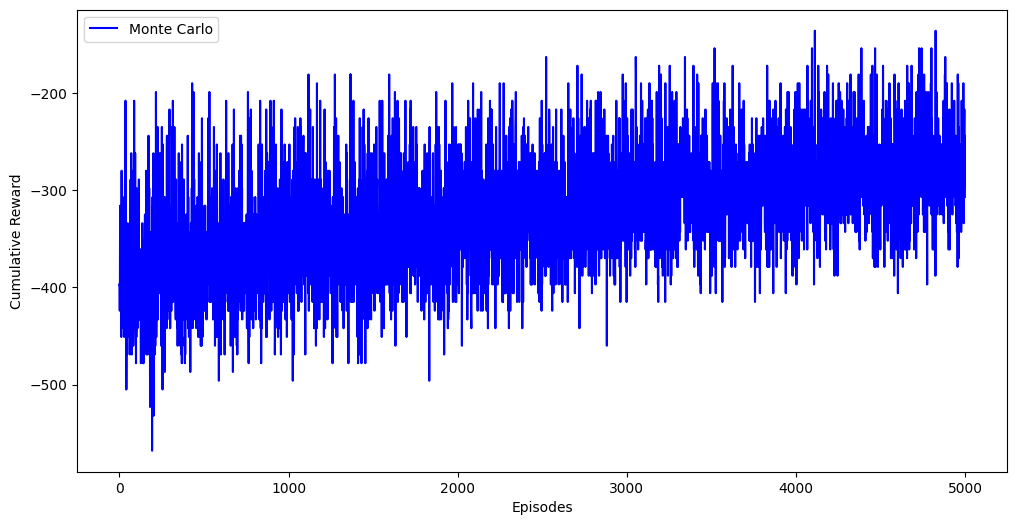

In [24]:
# Plot Results mc_rewards, 
print(mc_Q)
plot_rewards(mc_rewards)